# Data Loading 

This notebook serves to ingest all raw datasets, to clean them, harmonize & merge them if needed and save the cleaned CSVs. 



## 0. Import Dependencies

In [294]:
# import libraries
import pandas as pd
import numpy as np
import os
from pathlib import Path
#!pip install kagglehub
import kagglehub
import zipfile
import glob
import shutil
import re
import sys
#!{sys.executable} -m pip install pycountry
import pycountry
#!{sys.executable} -m pip install fuzzywuzzy
from fuzzywuzzy import fuzz


In [295]:
import seaborn as sns
import matplotlib.pyplot as plt

In [296]:
# folder path 
DATA_RAW = os.path.join("..", "data", "raw")
DATA_CLEAN = os.path.join("..", "data", "clean")
DATA_PROCESSED = os.path.join("..", "data", "processed")

In [297]:
# Seed for reproducibility
SEED = 42
np.random.seed(SEED)

## 1. File Paths

In [298]:
# folder path 
BASE_DIR = Path(r"C:/Users/black/Documents/Ironhack/final_project")
RAW_DIR = BASE_DIR / "data" / "raw"
CLEAN_DIR = BASE_DIR / "data" / "clean"
PROCESSED_DIR = BASE_DIR / "data" / "processed"

RAW_DIR.mkdir(parents=True, exist_ok=True)
CLEAN_DIR.mkdir(parents=True, exist_ok=True)
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

## 2. Helper Functions

### 2.1 Loading Dataset from Kaggle

In [299]:
def download_kagglehub_dataset(dataset_name, download_dir):
    """ Download & save dataset from KaggleHub."""
    try:
        print(f"Downloading dataset: {dataset_name}")
        path = kagglehub.dataset_download(dataset_name)
        print("Dataset downloaded to:", path)

        # Move downloaded files into your /data/raw folder
        dest = download_dir / dataset_name.replace("/", "_")
        dest.mkdir(parents=True, exist_ok=True)

        # Copy all downloaded files to the raw directory
        source_path = Path(path)
        for file in source_path.rglob("*"):  
            if file.is_file():
                relative_path = file.relative_to(source_path)
                new_file = dest / relative_path.name  
                
                if not new_file.exists():  
                    print(f"Copying: {file.name}")
                    shutil.copy2(file, new_file)

        print(f"Files moved to: {dest}")
        return dest

    except Exception as e:
        print(f"Error downloading dataset {dataset_name}: {e}")
        return None

def unzip_files_in_folder(folder_path):
    """Extract all ZIP files inside a folder."""
    zip_files = list(folder_path.glob("*.zip"))

    if not zip_files:
        return

    for z in zip_files:
        print(f"Extracting: {z.name}")
        try:
            with zipfile.ZipFile(z, "r") as zip_ref:
                zip_ref.extractall(folder_path)
        except Exception as e:
            print(f"Error unzipping {z.name}: {e}")



def load_csv_from_folder(folder_path):
    """Find and load the first CSV file in the folder with encoding handling."""
    csv_files = list(folder_path.glob("*.csv"))

    if not csv_files:
        print(f"No CSV files found in: {folder_path}")
        return None

    if len(csv_files) > 1:
        print(f"Multiple CSV files found, loading the first one:\n{csv_files}")

    file_to_load = csv_files[0]
    print(f"Loading CSV: {file_to_load.name}")

    encodings = ['utf-8', 'latin-1', 'iso-8859-1', 'cp1252']
    
    for encoding in encodings:
        try:
            print(f"  Trying {encoding}...")
            df = pd.read_csv(file_to_load, encoding=encoding)
            print(f"Success with {encoding}!")
            return df
        except UnicodeDecodeError:
            continue
        except Exception as e:
            print(f"Error: {e}")
            continue
    
    print("  All encodings failed. Loading with error='ignore'...")
    try:
        df = pd.read_csv(file_to_load, encoding='utf-8', encoding_errors='ignore')
        print("Loaded (some characters may be missing)")
        return df
    except Exception as e:
        print(f"Failed completely: {e}")
        return None


### 2.2 Standardization + Quick Clean

In [300]:
def standardize_columns(df):
    """Convert all column names to snake_case."""
    df.columns = (
        df.columns
        .str.strip()
        .str.lower()
        .str.replace(" ", "_")
        .str.replace("-", "_")
        .str.replace(r"[^a-zA-Z0-9_]", "", regex=True)
    )
    return df

In [301]:
def quick_clean(df):
    """Light cleaning: strip whitespace, unify types."""
    for col in df.select_dtypes(include="object"):
        df[col] = df[col].str.strip()
    return df

In [302]:
def save_df(df, path):
    """Save DataFrame cleanly."""
    path = Path(path)
    path.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(path, index=False)
    print(f"Saved to: {path}")


def load_kagglehub_csv(dataset_name, raw_dir, auto_save=True):
    """
    High-level helper:
    1. Download dataset from KaggleHub
    2. Load first CSV found
    3. Standardize columns & basic cleaning
    4. Auto-save cleaned version to RAW_DIR
    """
    # Create a clean filename for saving
    clean_filename = dataset_name.replace("/", "_") + "_cleaned.csv"
    save_path = raw_dir / clean_filename
    
    # Check if already exists
    if save_path.exists():
        print(f"Loading existing cleaned file: {clean_filename}")
        df = pd.read_csv(save_path)
        return df
    
    # Otherwise, download and process
    folder = download_kagglehub_dataset(dataset_name, raw_dir)
    if folder is None:
        return None
    
    unzip_files_in_folder(folder)

    df = load_csv_from_folder(folder)
    if df is None:
        return None

    df = standardize_columns(df)
    df = quick_clean(df)
    
    # Auto-save the cleaned version
    if auto_save:
        save_df(df, save_path, f"Saved cleaned data: {clean_filename}")
    
    return df

### 2.3 Loading + Saving

In [303]:
def download_kagglehub_dataset(dataset_name, download_dir):
    """ Download & save dataset from KaggleHub."""
    try:
        print(f"Downloading dataset: {dataset_name}")
        path = kagglehub.dataset_download(dataset_name)
        print("Dataset downloaded to:", path)

        # Move downloaded files into your /data/raw folder
        dest = download_dir / dataset_name.replace("/", "_")
        dest.mkdir(parents=True, exist_ok=True)

        # Copy all downloaded files to the raw directory
        source_path = Path(path)
        for file in source_path.rglob("*"):  
            if file.is_file():
                relative_path = file.relative_to(source_path)
                new_file = dest / relative_path.name  
                
                if not new_file.exists():  
                    print(f"Copying: {file.name}")
                    shutil.copy2(file, new_file)

        print(f"Files moved to: {dest}")
        return dest

    except Exception as e:
        print(f"Error downloading dataset {dataset_name}: {e}")
        return None

def unzip_files_in_folder(folder_path):
    """Extract all ZIP files inside a folder."""
    zip_files = list(folder_path.glob("*.zip"))

    if not zip_files:
        return

    for z in zip_files:
        print(f"Extracting: {z.name}")
        try:
            with zipfile.ZipFile(z, "r") as zip_ref:
                zip_ref.extractall(folder_path)
        except Exception as e:
            print(f"Error unzipping {z.name}: {e}")



def load_csv_from_folder(folder_path):
    """Find and load the first CSV file in the folder with encoding handling."""
    csv_files = list(folder_path.glob("*.csv"))

    if not csv_files:
        print(f"No CSV files found in: {folder_path}")
        return None

    if len(csv_files) > 1:
        print(f"Multiple CSV files found, loading the first one:\n{csv_files}")

    file_to_load = csv_files[0]
    print(f"Loading CSV: {file_to_load.name}")

    encodings = ['utf-8', 'latin-1', 'iso-8859-1', 'cp1252']
    
    for encoding in encodings:
        try:
            print(f"  Trying {encoding}...")
            df = pd.read_csv(file_to_load, encoding=encoding)
            print(f"Success with {encoding}!")
            return df
        except UnicodeDecodeError:
            continue
        except Exception as e:
            print(f"Error: {e}")
            continue
    
    print("  All encodings failed. Loading with error='ignore'...")
    try:
        df = pd.read_csv(file_to_load, encoding='utf-8', encoding_errors='ignore')
        print("Loaded (some characters may be missing)")
        return df
    except Exception as e:
        print(f"Failed completely: {e}")
        return None
def standardize_columns(df):
    """Convert all column names to snake_case."""
    df.columns = (
        df.columns
        .str.strip()
        .str.lower()
        .str.replace(" ", "_")
        .str.replace("-", "_")
        .str.replace(r"[^a-zA-Z0-9_]", "", regex=True)
    )
    return df
def quick_clean(df):
    """Light cleaning: strip whitespace, unify types."""
    for col in df.select_dtypes(include="object"):
        df[col] = df[col].str.strip()
    return df
def load_kagglehub_csv(dataset_name, raw_dir):
    """
    High-level helper:
    1. Download dataset from KaggleHub
    2. Load first CSV found
    3. Standardize columns & basic cleaning
    """
    folder = download_kagglehub_dataset(dataset_name, raw_dir)
    if folder is None:
        return None
    
    unzip_files_in_folder(folder)

    df = load_csv_from_folder(folder)
    if df is None:
        return None

    df = standardize_columns(df)
    df = quick_clean(df)
    return df
def save_df(df, path):
    """Save DataFrame cleanly."""
    df.to_csv(path, index=False)
    print(f"Saved to: {path}")

### 2.4 ISO Code

In [304]:
def get_iso_code(country_name, method='alpha_3'):
    """
    Get ISO code for a country name using pycountry.
    """
    if pd.isna(country_name) or country_name == '':
        return None
    
    country_name = str(country_name).strip()
    
    # Direct lookup by name
    try:
        country = pycountry.countries.get(name=country_name)
        if country:
            return country.alpha_3 if method == 'alpha_3' else country.alpha_2
    except:
        pass
    
    # Try official name
    try:
        country = pycountry.countries.get(official_name=country_name)
        if country:
            return country.alpha_3 if method == 'alpha_3' else country.alpha_2
    except:
        pass
    
    # Fuzzy matching for close matches
    best_match = None
    best_score = 0
    
    for country in pycountry.countries:
        # Check name
        score = fuzz.ratio(country_name.lower(), country.name.lower())
        if score > best_score:
            best_score = score
            best_match = country
        
        # Check common_name if exists
        if hasattr(country, 'common_name'):
            score = fuzz.ratio(country_name.lower(), country.common_name.lower())
            if score > best_score:
                best_score = score
                best_match = country
        
        # Check official_name if exists
        if hasattr(country, 'official_name'):
            score = fuzz.ratio(country_name.lower(), country.official_name.lower())
            if score > best_score:
                best_score = score
                best_match = country
    
    # Only return if confidence is high enough (>85% match)
    if best_score >= 85 and best_match:
        return best_match.alpha_3 if method == 'alpha_3' else best_match.alpha_2
    
    return None


def create_country_mapping():
    """
    Create a manual mapping for countries that pycountry struggles with.
    This handles common variations and special cases.
    """
    manual_mapping = {
        # Common variations
        'United States': 'USA',
        'USA': 'USA',
        'US': 'USA',
        'United States of America': 'USA',
        'UK': 'GBR',
        'United Kingdom': 'GBR',
        'England': 'GBR',
        'Great Britain': 'GBR',
        'Russia': 'RUS',
        'Russian Federation': 'RUS',
        'South Korea': 'KOR',
        'Korea, Republic of': 'KOR',
        'North Korea': 'PRK',
        "Korea, Democratic People's Republic of": 'PRK',
        'Vietnam': 'VNM',
        'Viet Nam': 'VNM',
        'Syria': 'SYR',
        'Syrian Arab Republic': 'SYR',
        'Iran': 'IRN',
        'Iran, Islamic Republic of': 'IRN',
        'Venezuela': 'VEN',
        'Venezuela, Bolivarian Republic of': 'VEN',
        'Bolivia': 'BOL',
        'Bolivia, Plurinational State of': 'BOL',
        'Tanzania': 'TZA',
        'Tanzania, United Republic of': 'TZA',
        'Moldova': 'MDA',
        'Moldova, Republic of': 'MDA',
        'Laos': 'LAO',
        "Lao People's Democratic Republic": 'LAO',
        'Palestine': 'PSE',
        'Palestinian Territory': 'PSE',
        'Palestinian Territories': 'PSE',
        'State of Palestine': 'PSE',
        'Czechia': 'CZE',
        'Czech Republic': 'CZE',
        'Turkey': 'TUR',
        'Türkiye': 'TUR',
        'Cape Verde': 'CPV',
        'Cabo Verde': 'CPV',
        'Congo': 'COG',
        'Republic of the Congo': 'COG',
        'Congo, Republic of the': 'COG',
        'Democratic Republic of the Congo': 'COD',
        'Congo, Democratic Republic of the': 'COD',
        'DR Congo': 'COD',
        'DRC': 'COD',
        'Ivory Coast': 'CIV',
        "Côte d'Ivoire": 'CIV',
        'Cote d\'Ivoire': 'CIV',
        'Brunei': 'BRN',
        'Brunei Darussalam': 'BRN',
        'Micronesia': 'FSM',
        'Micronesia, Federated States of': 'FSM',
        'Macedonia': 'MKD',
        'North Macedonia': 'MKD',
        'The former Yugoslav Republic of Macedonia': 'MKD',
        'Eswatini': 'SWZ',
        'Swaziland': 'SWZ',
        'East Timor': 'TLS',
        'Timor-Leste': 'TLS',
        'Burma': 'MMR',
        'Myanmar': 'MMR',
        'Gambia': 'GMB',
        'The Gambia': 'GMB',
        'Bahamas': 'BHS',
        'The Bahamas': 'BHS',
        'Congo Democratic Republic': 'COD',
        'Congo, Dem. Rep.': 'COD',
        'Bahamas, The': 'BHS',  
        'Congo, Rep.': 'COG',
        'Egypt, Arab Rep.': 'EGY',
        'Gambia, The': 'GMB',
        'Hong Kong SAR, China': 'HKG',
        'Hong Kong, China': 'HKG',
        'Macau, China': 'MAC',
        'Taiwan, China': 'TWN',
        'Iran, Islamic Rep.': 'IRN',
        'Korea, Rep.': 'KOR',
        'Lao PDR': 'LAO',
        'Venezuela, RB': 'VEN',
        'Yemen, Rep.': 'YEM',
        'Channel Islands': 'GBR',
        'United States Virgin Islands': 'VIR',
        'Netherlands (Kingdom of the)': 'NLD',
        'Eswatini (Kingdom of)' : 'SWZ',
        'Hong Kong, China (SAR)' : 'HKG'
    }
    return manual_mapping


def add_iso_codes(df, country_col='country', method='alpha_3', new_col_name='iso'):
    """
    Add ISO codes to a DataFrame with a country column.
    """
    if country_col not in df.columns:
        print(f"Warning: Column '{country_col}' not found in DataFrame")
        return df, {}
    
    df = df.copy()
    manual_mapping = create_country_mapping()
    
    # Apply manual mapping first, then pycountry lookup
    def get_code(country_name):
        if pd.isna(country_name):
            return None
        
        country_name_clean = str(country_name).strip()
        
        # Check manual mapping first
        if country_name_clean in manual_mapping:
            return manual_mapping[country_name_clean]
        
        # Otherwise use pycountry
        return get_iso_code(country_name_clean, method=method)
    
    # Add ISO codes
    df[new_col_name] = df[country_col].apply(get_code)
    
    # Identify unmatched countries
    unmatched = df[df[new_col_name].isna()][country_col].unique()
    unmatched_dict = {country: None for country in unmatched if pd.notna(country)}
    
    if unmatched_dict:
        print(f"\nWarning: {len(unmatched_dict)} countries could not be matched:")
        for country in sorted(unmatched_dict.keys()):
            print(f"  - {country}")
        print("\nConsider adding these to the manual mapping.")
    else:
        print(f"All countries successfully matched!")
    
    # Summary statistics
    total = len(df)
    matched = df[new_col_name].notna().sum()
    print(f"\nMatching Summary:")
    print(f"   Total rows: {total}")
    print(f"   Matched: {matched} ({matched/total*100:.1f}%)")
    print(f"   Unmatched: {total - matched} ({(total-matched)/total*100:.1f}%)")
    
    return df, unmatched_dict


def standardize_all_countries(datasets_dict):
    """
    Add ISO codes to all datasets in a dictionary.
    """
    updated_datasets = {}
    all_unmatched = {}
    
    country_columns = {
        'domestic': None,  
        'vawg': 'country',
        'freedom': 'country',
        'danger': 'country',
        'gdp': 'country',  
        'wage_gap': None,  
        'unemployment': 'country',
        'gii': 'country',
        'legal': 'country',
        'partner_violence': 'country',
        'eq_laws': 'continent', 
        "wpsi" : "country",
    }
    
    for dataset_name, df in datasets_dict.items():
        print(f"\n{'='*60}")
        print(f"Processing: {dataset_name.upper()}")
        print(f"{'='*60}")
        
        country_col = country_columns.get(dataset_name)
        
        # Skip if no country column
        if country_col is None:
            print(f"Skipping (no country column or already has ISO)")
            updated_datasets[dataset_name] = df
            continue
        
        # Skip if already has ISO column
        if 'iso' in df.columns:
            print(f"Already has 'iso' column")
            updated_datasets[dataset_name] = df
            continue
        
        # Add ISO codes
        updated_df, unmatched = add_iso_codes(
            df, 
            country_col=country_col,
            method='alpha_3',
            new_col_name='iso'
        )
        
        updated_datasets[dataset_name] = updated_df
        if unmatched:
            all_unmatched[dataset_name] = unmatched
    
    if all_unmatched:
        print("\nDatasets with unmatched countries:")
        for dataset, countries in all_unmatched.items():
            print(f"\n  {dataset.upper()}: {len(countries)} unmatched")
            for country in sorted(countries.keys())[:11]:  
                print(f"    - {country}")
            if len(countries) > 11:
                print(f"    ... and {len(countries) - 11} more")
    else:
        print("\nAll countries matched across all datasets!")
    
    return updated_datasets, all_unmatched


## 2. Load all Data

### 2.1 Load & Quick Clean

In [305]:
dv_df_clean = load_kagglehub_csv("fahmidachowdhury/domestic-violence-against-women", CLEAN_DIR)


Dataset downloaded to: C:\Users\black\.cache\kagglehub\datasets\fahmidachowdhury\domestic-violence-against-women\versions\1
Files moved to: C:\Users\black\Documents\Ironhack\final_project\data\clean\fahmidachowdhury_domestic-violence-against-women
Loading CSV: Domestic violence.csv
  Trying utf-8...
Success with utf-8!


In [306]:
vawg_df_clean = load_kagglehub_csv("whenamancodes/violence-against-women-girls", CLEAN_DIR)

Dataset downloaded to: C:\Users\black\.cache\kagglehub\datasets\whenamancodes\violence-against-women-girls\versions\1
Files moved to: C:\Users\black\Documents\Ironhack\final_project\data\clean\whenamancodes_violence-against-women-girls
Loading CSV: Violence Against Women  Girls Data.csv
  Trying utf-8...
Success with utf-8!


In [307]:
hfi_df_clean = load_kagglehub_csv("gsutters/the-human-freedom-index", CLEAN_DIR)

Dataset downloaded to: C:\Users\black\.cache\kagglehub\datasets\gsutters\the-human-freedom-index\versions\5
Files moved to: C:\Users\black\Documents\Ironhack\final_project\data\clean\gsutters_the-human-freedom-index
Multiple CSV files found, loading the first one:
[WindowsPath('C:/Users/black/Documents/Ironhack/final_project/data/clean/gsutters_the-human-freedom-index/hfi_cc_2018.csv'), WindowsPath('C:/Users/black/Documents/Ironhack/final_project/data/clean/gsutters_the-human-freedom-index/hfi_cc_2019.csv'), WindowsPath('C:/Users/black/Documents/Ironhack/final_project/data/clean/gsutters_the-human-freedom-index/hfi_cc_2020.csv'), WindowsPath('C:/Users/black/Documents/Ironhack/final_project/data/clean/gsutters_the-human-freedom-index/hfi_cc_2021.csv'), WindowsPath('C:/Users/black/Documents/Ironhack/final_project/data/clean/gsutters_the-human-freedom-index/hfi_cc_2022.csv')]
Loading CSV: hfi_cc_2018.csv
  Trying utf-8...
Success with utf-8!


In [308]:
mdc_df_clean = load_kagglehub_csv("arpitsinghaiml/most-dangerous-countries-for-women-2024", CLEAN_DIR)

Dataset downloaded to: C:\Users\black\.cache\kagglehub\datasets\arpitsinghaiml\most-dangerous-countries-for-women-2024\versions\1
Files moved to: C:\Users\black\Documents\Ironhack\final_project\data\clean\arpitsinghaiml_most-dangerous-countries-for-women-2024
Loading CSV: most-dangerous-countries-for-women-2024.csv
  Trying utf-8...
Success with utf-8!


In [309]:
gdp_df_clean = load_kagglehub_csv("rajkumarpandey02/human-development-index-and-components", CLEAN_DIR)

Dataset downloaded to: C:\Users\black\.cache\kagglehub\datasets\rajkumarpandey02\human-development-index-and-components\versions\1
Files moved to: C:\Users\black\Documents\Ironhack\final_project\data\clean\rajkumarpandey02_human-development-index-and-components
Loading CSV: Human Development Index and Components.csv
  Trying utf-8...
  Trying latin-1...
Success with latin-1!


In [310]:
gwg_df_clean = load_kagglehub_csv("mpwolke/cusersmarildownloadsgapcsv", CLEAN_DIR)

Dataset downloaded to: C:\Users\black\.cache\kagglehub\datasets\mpwolke\cusersmarildownloadsgapcsv\versions\1
Files moved to: C:\Users\black\Documents\Ironhack\final_project\data\clean\mpwolke_cusersmarildownloadsgapcsv
Loading CSV: gap.csv
  Trying utf-8...
Success with utf-8!


In [311]:
gud_df_clean = load_kagglehub_csv("sazidthe1/global-unemployment-data", CLEAN_DIR)

Dataset downloaded to: C:\Users\black\.cache\kagglehub\datasets\sazidthe1\global-unemployment-data\versions\1
Files moved to: C:\Users\black\Documents\Ironhack\final_project\data\clean\sazidthe1_global-unemployment-data
Loading CSV: global_unemployment_data.csv
  Trying utf-8...
Success with utf-8!


In [312]:
wed_df_clean = load_kagglehub_csv("nelgiriyewithana/world-educational-data", CLEAN_DIR)

Dataset downloaded to: C:\Users\black\.cache\kagglehub\datasets\nelgiriyewithana\world-educational-data\versions\1
Files moved to: C:\Users\black\Documents\Ironhack\final_project\data\clean\nelgiriyewithana_world-educational-data
Loading CSV: Global_Education.csv
  Trying utf-8...
  Trying latin-1...
Success with latin-1!


In [313]:
gii_df_clean = load_kagglehub_csv("gianinamariapetrascu/gender-inequality-index", CLEAN_DIR)

Dataset downloaded to: C:\Users\black\.cache\kagglehub\datasets\gianinamariapetrascu\gender-inequality-index\versions\2
Files moved to: C:\Users\black\Documents\Ironhack\final_project\data\clean\gianinamariapetrascu_gender-inequality-index
Loading CSV: Gender_Inequality_Index.csv
  Trying utf-8...
Success with utf-8!


In [314]:
lf_df_clean = load_kagglehub_csv("willianoliveiragibin/legal-frameworks", CLEAN_DIR)

Dataset downloaded to: C:\Users\black\.cache\kagglehub\datasets\willianoliveiragibin\legal-frameworks\versions\1
Files moved to: C:\Users\black\Documents\Ironhack\final_project\data\clean\willianoliveiragibin_legal-frameworks
Loading CSV: legal-frameworks-gender-equality-within-marriage-and-family new.csv
  Trying utf-8...
Success with utf-8!


In [315]:
aip_df_raw = pd.read_csv(r"data\raw\physical_sexual_abuse_current_or_former_partner.csv")
aip_df_clean = quick_clean(aip_df_raw)
aip_df_clean = standardize_columns(aip_df_clean)

In [316]:
gel_df_clean = load_kagglehub_csv("shreyasur965/global-gender-equality-in-business-laws1970-2023", CLEAN_DIR)

Dataset downloaded to: C:\Users\black\.cache\kagglehub\datasets\shreyasur965\global-gender-equality-in-business-laws1970-2023\versions\2
Files moved to: C:\Users\black\Documents\Ironhack\final_project\data\clean\shreyasur965_global-gender-equality-in-business-laws1970-2023
Loading CSV: women-rights.csv
  Trying utf-8...
Success with utf-8!


### 2.2 Sanity Check

In [317]:
datasets = {
    "domestic": dv_df_clean,
    "vawg": vawg_df_clean,
    "freedom": hfi_df_clean,
    "danger": mdc_df_clean,
    "gdp": gdp_df_clean,
    "wage_gap": gwg_df_clean,
    "unemployment": gud_df_clean,
    "gii": gii_df_clean,
    "legal": lf_df_clean,
    "partner_violence": aip_df_clean,
    "eq_laws": gel_df_clean
}

for name, df in datasets.items():
    print(f"--- {name.upper()} ---")
    print("Shape:", df.shape)
    print("Columns:", df.columns.tolist())
    print("Missing values:", df.isna().sum().sum())
    print()

--- DOMESTIC ---
Shape: (347, 7)
Columns: ['sl_no', 'age', 'education', 'employment', 'income', 'marital_status', 'violence']
Missing values: 0

--- VAWG ---
Shape: (12600, 8)
Columns: ['recordid', 'country', 'gender', 'demographics_question', 'demographics_response', 'question', 'survey_year', 'value']
Missing values: 1413

--- FREEDOM ---
Shape: (1458, 123)
Columns: ['year', 'iso_code', 'countries', 'region', 'pf_rol_procedural', 'pf_rol_civil', 'pf_rol_criminal', 'pf_rol', 'pf_ss_homicide', 'pf_ss_disappearances_disap', 'pf_ss_disappearances_violent', 'pf_ss_disappearances_organized', 'pf_ss_disappearances_fatalities', 'pf_ss_disappearances_injuries', 'pf_ss_disappearances', 'pf_ss_women_fgm', 'pf_ss_women_missing', 'pf_ss_women_inheritance_widows', 'pf_ss_women_inheritance_daughters', 'pf_ss_women_inheritance', 'pf_ss_women', 'pf_ss', 'pf_movement_domestic', 'pf_movement_foreign', 'pf_movement_women', 'pf_movement', 'pf_religion_estop_establish', 'pf_religion_estop_operate', 'pf_re

## 3. Select Data 

### 3.1 Domestic Violence

- droping case number
- no missing values
- potential further processing:
    income bucktes (no, low, middle, high)

In [318]:
dv_df_pro = dv_df_clean.drop(columns="sl_no")

categorical_columns = ['education', 'employment', 'marital_status', 'violence']
for col in categorical_columns:
    dv_df_pro[col] = dv_df_pro[col].astype('category')

numeric_cols = ["age", "income"]
for col in numeric_cols:
    dv_df_pro[col] = pd.to_numeric(dv_df_pro[col], errors='coerce')

### 3.2 Violence Against Women & Girls

In [319]:
vawg_df_pro = vawg_df_clean.drop(columns="survey_year")

#create demographic group column (text normalized)
def normalize_text(s: str) -> str:
    s = s.lower()
    s = s.replace(" ", "_")
    s = s.replace("-", "_")
    s = s.replace(",", "")
    return s

vawg_df_pro["demographic_group"] = (
    vawg_df_pro["demographics_question"].apply(normalize_text)
    + "_" +
    vawg_df_pro["demographics_response"].apply(normalize_text)
)

In [320]:
# pivot table
def pivot_vawg(df: pd.DataFrame) -> pd.DataFrame:

    pivot_df = df.pivot_table(
        index=["country", "question"],
        columns="demographic_group",
        values="value",
        aggfunc="mean"
    )

    pivot_df = pivot_df.reset_index()

    # Fix column names: remove pivot table formatting
    pivot_df.columns = [str(col) for col in pivot_df.columns]

    return pivot_df


vawg_df_pro = pivot_vawg(vawg_df_pro)




In [321]:
categorical_columns = ['country', 'question']
for col in categorical_columns:
    vawg_df_pro[col] = vawg_df_pro[col].astype('category')

In [322]:
# Impute missing values

def impute_vawg(df: pd.DataFrame) -> pd.DataFrame:
    """
    Impute missing values in VAWG demographic % data.
    Strategy:
        1) If missing → country median for that question
        2) If still missing → global median for that demographic column
    """
    id_cols = ["country", "question"]
    feature_cols = [c for c in df.columns if c not in id_cols]

    for feature in feature_cols:
        df[feature] = df.groupby(["country", "question"])[feature].transform(
            lambda x: x.fillna(x.median())
        )

    for feature in feature_cols:
        if df[feature].isna().sum() > 0:
            df[feature] = df[feature].fillna(df[feature].median())

    return df

# Clean Question

def clean_question_text(df: pd.DataFrame) -> pd.DataFrame:
    """
    Standardize violence-related question text to ensure consistent keys.
    """
    df["question"] = df["question"].str.replace(r"^\.\.\.\s*", "", regex=True)

    # Text normalization: lowercase, strip, unify spaces
    df["question"] = (
        df["question"]
        .str.lower()
        .str.strip()
        .str.replace(r"\s+", " ", regex=True)
    )

    # Unify similar question labels
    replacements = {
        "if she burns food": "if she burns the food",
        "if she burns the food?": "if she burns the food",
        "if she goes out without telling him": "if she goes out without informing him",
    }

    df["question"] = df["question"].replace(replacements)

    return df


# romve columns with high missing values

def drop_sparse_columns(df: pd.DataFrame, threshold: float = 0.5) -> pd.DataFrame:
    """
    Drops columns with more than threshold % missing values.
    threshold=0.5 -> drop columns with >50% missing.
    """

    id_cols = ["country", "question"]
    feature_cols = [c for c in df.columns if c not in id_cols]

    missing_ratio = df[feature_cols].isna().mean()
    drop_cols = missing_ratio[missing_ratio > threshold].index.tolist()

    print(f"Dropping {len(drop_cols)} sparse columns: {drop_cols}")

    df = df.drop(columns=drop_cols)

    return df


# unique key (country + question)

def create_unique_key(df: pd.DataFrame) -> pd.DataFrame:
    """
    for later modeling
    """
    df["key"] = df["country"].astype(str) + " | " + df["question"].astype(str)
    return df


# pipeline

def clean_vawg_full(vawg_df_pro: pd.DataFrame) -> pd.DataFrame:
    df = vawg_df_pro.copy()
    df = clean_question_text(df)
    df = impute_vawg(df)
    df = drop_sparse_columns(df, threshold=0.5)
    df = create_unique_key(df)
    return df.reset_index(drop=True)


# apply

vawg_df_pro = clean_vawg_full(vawg_df_pro)
vawg_df_pro.head()

C:\Users\black\AppData\Local\Temp\ipykernel_38436\3198293871.py:14: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\black\AppData\Local\Temp\ipykernel_38436\3198293871.py:14: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\black\AppData\Local\Temp\ipykernel_38436\3198293871.py:14: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\black\AppData\Local\Temp\ipykernel_38436\3198293871.py:14: FutureWarning:

Dropping 0 sparse columns: []


,country,question,age_15_24,age_25_34,age_35_49,education_higher,education_no_education,education_primary,education_secondary,employment_employed_for_cash,employment_employed_for_kind,employment_unemployed,marital_status_married_or_living_together,marital_status_never_married,marital_status_widowed_divorced_separated,residence_rural,residence_urban,key
0,Afghanistan,for at least one specific reason,77.10,76.00,76.30,58.30,79.20,73.95,72.80,76.40,80.20,73.75,76.60,15.1,58.20,79.10,66.95,Afghanistan | for at least one specific reason
1,Afghanistan,if she argues with him,50.95,52.30,53.20,34.55,55.20,48.95,49.10,51.65,50.65,50.45,52.50,15.1,43.30,53.80,47.55,Afghanistan | if she argues with him
2,Afghanistan,if she burns the food,13.35,13.20,13.70,7.30,14.85,10.05,10.40,14.60,13.85,11.60,13.40,15.1,10.05,13.90,11.45,Afghanistan | if she burns the food
3,Afghanistan,if she goes out without informing him,65.50,64.45,62.85,42.35,67.20,60.00,58.85,63.80,66.85,60.90,64.20,15.1,47.50,67.45,52.45,Afghanistan | if she goes out without informin...
4,Afghanistan,if she neglects the children,35.65,38.60,36.90,27.15,39.30,36.45,33.70,36.85,39.95,40.20,37.35,15.1,36.20,38.50,33.15,Afghanistan | if she neglects the children


### 3.3 Violence/Sexual Abuse Current or former partner

In [323]:
# only select needed values
aip_df_pro = aip_df_clean[["location", "value"]]

# remove everything in square brackets including the brackets
aip_df_pro['value'] = aip_df_pro['value'].str.replace(r'\s*\[.*?\]', '', regex=True)

# trip any whitespace
aip_df_pro['value'] = aip_df_pro['value'].str.strip()

# rename column
aip_df_pro = aip_df_pro.rename(columns={"location" :  "country"})

# change value type
cat_col_vawg= ['country']
for col in cat_col_vawg:
    aip_df_pro[col] = aip_df_pro[col].astype('category')


num_col_vawg= ['value']
for col in num_col_vawg:
    aip_df_pro[col] = aip_df_pro[col].astype('int')



C:\Users\black\AppData\Local\Temp\ipykernel_38436\1145058609.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\black\AppData\Local\Temp\ipykernel_38436\1145058609.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### 3.4 Human Freedom Index

In [324]:
hfi_df_clean = pd.read_csv(r"data\clean\gsutters_the-human-freedom-index\hfi_cc_2022.csv")
hfi_df_clean.columns.tolist()

# choose only needed data 
hfi_df_pro = hfi_df_clean[["year", "countries", "region", "hf_score", 'pf_score', 'ef_score']]

# only use latest data (2020) -> all available, better as mean from all years due to NaNs
hfi_df_pro  = hfi_df_pro[hfi_df_pro["year"] == 2020]

# drop year column 
hfi_df_pro = hfi_df_pro.drop(columns=["year"])

# rename columns
hfi_df_pro = hfi_df_pro.rename(columns={"countries" : "country"})

# change value type
cat_col_hfi = ['country', 'region']
for col in cat_col_hfi:
    hfi_df_pro[col] = hfi_df_pro[col].astype('category')



### 3.5 Most Dangerous Countries

In [325]:
mdc_df_clean.head()

# rename columns
mdc_df_clean = mdc_df_clean.rename(columns={
    "mostdangerouscountriesforwomen_womenpeaceandsecurityindex_score_2023" : "wpsi",
    "mostdangerouscountriesforwomen_womensdangerindexwdi_totalscore_2019" : "wdi",
    "mostdangerouscountriesforwomen_wdistreetsafety_2019" : "wss",
    "mostdangerouscountriesforwomen_wdiintentionalhomicide_2019" : "ih",
    "mostdangerouscountriesforwomen_wdinonpartnerviolence_2019" : "npv",
    "mostdangerouscountriesforwomen_wdiintimatepartnerviolence_2019" : "ipv",
    "mostdangerouscountriesforwomen_wdilegaldiscrimination_2019" : "ld",
    "mostdangerouscountriesforwomen_wdiglobalgendergap_2019" : "ggg",
    "mostdangerouscountriesforwomen_wdigenderinequality_2019" : "gi",
    "mostdangerouscountriesforwomen_wdiattitudestowardviolence_2019" : "atv"
    })


# split into two data sets due to missing values
# Women Peace and Security Index 2023 (all countries): WPSI
wpsi_df_pro = mdc_df_clean[["country", "wpsi"]]

# Women Danger index + respective parameters; remove ggg & gi as given in other data
mdc_df_pro = mdc_df_clean.drop(columns=["wpsi", "ggg", "gi"])

# drop missing values
mdc_df_pro = mdc_df_pro.dropna()

# reset index
mdc_df_pro = mdc_df_pro.reset_index(drop=True)


### 3.6 GDP

In [326]:
gdp_df_clean.head()

,hdi_rank,country,human_development,human_development_index_hdi,life_expectancy_at_birth,expected_years_of_schooling,mean_years_of_schooling,gross_national_income_gni_per_capita,gni_per_capita_rank_minus_hdi_rank,hdi_rank1,unnamed_10,unnamed_11
0,1,Switzerland,VERY HIGH,0.962,84.0,16.5,13.9,"66,933",5,3,NaN,NaN
1,2,Norway,VERY HIGH,0.961,83.2,18.2,13.0,"64,660",6,1,NaN,NaN
2,3,Iceland,VERY HIGH,0.959,82.7,19.2,13.8,"55,782",11,2,NaN,NaN
3,4,"Hong Kong, China (SAR)",VERY HIGH,0.952,85.5,17.3,12.2,"62,607",6,4,NaN,NaN
4,5,Australia,VERY HIGH,0.951,84.5,21.1,12.7,"49,238",18,5,NaN,NaN


In [327]:
# keeping relevant columns
gdp_df_pro = gdp_df_clean[['country', 'gross_national_income_gni_per_capita']]

# rename columns
gdp_df_pro = gdp_df_pro.rename(columns={'gross_national_income_gni_per_capita' : "gni_pc"})

# change value type
gdp_df_pro["gni_pc"] = (
    gdp_df_pro["gni_pc"]
        .astype(str)           
        .str.replace(",", ".")     
        .str.replace(" ", "")     
)

gdp_df_pro["gni_pc"] = pd.to_numeric(
    gdp_df_pro["gni_pc"], 
    errors="coerce"               
)

cat_col_gdp= ['country']
for col in cat_col_gdp:
    gdp_df_pro[col] = gdp_df_pro[col].astype('category')

# manual fill missing values
gdp_df_pro.iloc[191, 1] = 1.147
gdp_df_pro.iloc[192, 1] = 223.823



In [328]:
gdp_df_pro[gdp_df_pro["country"] == "Burundi"]

,country,gni_pc
186,Burundi,732.0


In [329]:
def categorize_income(gni_pc):
        if pd.isna(gni_pc):
            return None
        elif gni_pc < 2.133: 
            return 'Low Income'
        elif gni_pc < 4.516:
            return 'Lower-Middle Income'
        elif gni_pc < 14.006:
            return 'Upper-Middle Income'
        else:
            return 'High Income'
    
gdp_df_pro['income_category'] = gdp_df_pro['gni_pc'].apply(categorize_income)

In [330]:
gdp_df_pro[gdp_df_pro["income_category"] == "Low Income"]

,country,gni_pc,income_category
168,Malawi,1.466,Low Income
172,Madagascar,1.484,Low Income
175,Eritrea,1.729,Low Income
176,Guinea-Bissau,1.908,Low Income
177,Liberia,1.289,Low Income
178,Congo (Democratic Republic of the),1.076,Low Income
179,Afghanistan,1.824,Low Income
180,Sierra Leone,1.622,Low Income
182,Yemen,1.314,Low Income
183,Burkina Faso,2.118,Low Income


In [331]:
# log GNI to reduce skeweness
gdp_df_pro["log_GNI"] = np.log10(gdp_df_pro["gni_pc"])

# drop non-log GDP
gdp_df_pro = gdp_df_pro.drop(columns=["gni_pc"])

### 3.7 Gender Wage Gap

In [332]:
# data into right format
column_names = ['iso', 'indicator', 'subject', 'measure', 'frequency', 'time', 'gwg_%']

gwg_df_pro = gwg_df_clean['locationindicatorsubjectmeasurefrequencytimevalue'].str.split(';', expand=True)

gwg_df_pro.columns = column_names

# only select useful data
gwg_df_pro = gwg_df_pro[gwg_df_pro["time"] == "2018"]  

gwg_df_pro = gwg_df_pro[gwg_df_pro["subject"] != "SELFEMPLOYED"]

gwg_df_pro = gwg_df_pro[["iso", "gwg_%"]]

# change gwg_% format 
gwg_df_pro["gwg_%"] = gwg_df_pro["gwg_%"].astype(str).str.split(".").str[:2].str.join(".").astype(float)

# reset index
gwg_df_pro = gwg_df_pro.reset_index(drop=True)

# change value type
cat_col_gwg= ["iso"]
for col in cat_col_gwg:
    gwg_df_pro[col] = gwg_df_pro[col].astype('category')



### 3.8 Global Unemployment Data

In [333]:
gud_df_clean.head()

# select relevant columns
gud_df_pro = gud_df_clean[["country_name", "sex", "age_group", "2024"]]

# rename columnc 
gud_df_pro = gud_df_pro.rename(columns={"country_name" : "country", "age_group" : "age", "2024" : "percentage_unemployement"})

# handle missing values
gud_df_pro[gud_df_pro.isna().any(axis=1)]

# fill Palestinian Territories with data from 2022
gud_df_pro.iloc[756, 3] = 56.709
gud_df_pro.iloc[757, 3] = 36.385
gud_df_pro.iloc[758, 3] = 40.045
gud_df_pro.iloc[759, 3] = 31.563
gud_df_pro.iloc[760, 3] = 16.772
gud_df_pro.iloc[761, 3] = 20.186

# fill Ukraine with data from 2021
gud_df_pro.iloc[1056, 3] = 20.412
gud_df_pro.iloc[1057, 3] = 9.519
gud_df_pro.iloc[1058, 3] = 10.143
gud_df_pro.iloc[1059, 3] = 18.085
gud_df_pro.iloc[1060, 3] = 8.933
gud_df_pro.iloc[1061, 3] = 9.543

# change value type
cat_col_gud= ["country", "sex", "age"]
for col in cat_col_gud:
    gud_df_pro[col] = gud_df_pro[col].astype('category')

# reset index
gud_df_pro  = gud_df_pro.reset_index(drop=True)


### 3.9 Global Ineguality Index

In [334]:
gii_df_clean[gii_df_clean.isna().any(axis=1)]

# missing values handling open

,country,human_development,gii,rank,maternal_mortality,adolescent_birth_rate,seats_parliament,f_secondary_educ,m_secondary_educ,f_labour_force,m_labour_force
3,Hong Kong,Very high,NaN,NaN,NaN,1.6,NaN,77.1,83.4,53.5,65.8
15,Liechtenstein,Very high,NaN,NaN,NaN,3.0,28.0,NaN,NaN,NaN,NaN
39,Andorra,Very high,NaN,NaN,NaN,5.9,46.4,70.7,72.4,NaN,NaN
43,San Marino,Very high,NaN,NaN,NaN,3.8,33.3,81.8,84.3,NaN,NaN
68,Grenada,High,NaN,NaN,25.0,32.7,32.1,NaN,NaN,NaN,NaN
70,Antigua and Barbuda,High,NaN,NaN,42.0,33.1,31.4,NaN,NaN,NaN,NaN
71,Seychelles,High,NaN,NaN,53.0,53.4,22.9,NaN,NaN,NaN,NaN
74,Saint Kitts and Nevis,High,NaN,NaN,NaN,38.2,25.0,NaN,NaN,NaN,NaN
81,Palau,High,NaN,NaN,NaN,42.5,6.9,96.9,97.3,NaN,NaN
101,Dominica,High,NaN,NaN,NaN,38.5,34.4,NaN,NaN,NaN,NaN


### 3.10 Legal Frameworks


In [335]:
# Legal frameworks that promote, enforce and monitor gender equality (percentage of achievement, 0 - 100)

lf_df_pro = lf_df_clean.drop(columns = "unnamed_3")
lf_df_pro = lf_df_pro.rename(columns = {"511___legal_frameworks" : "percent_leg_equ_achiev_marriage"})
lf_df_pro = lf_df_pro[lf_df_pro["year"] == 2022]
lf_df_pro = lf_df_pro.drop(columns="year")

cat_col_lf= ["country"]
for col in cat_col_lf:
    lf_df_pro[col] = lf_df_pro[col].astype('category')

### 3.11 Equality Laws

In [336]:
# only select latest data
gel_df_pro = gel_df_clean[gel_df_clean["year"] == 2023]

# rename columns
gel_df_pro = gel_df_pro.rename(columns={"entity" : "continent"})

# drop unnessecary columns
gel_df_pro = gel_df_pro.drop(columns=["year"])

# reset index
gel_df_pro = gel_df_pro.reset_index(drop=True)

## 4. ISO Country Column

In [337]:
# datasets dictionary
datasets = {
    "domestic": dv_df_pro,
    "vawg": vawg_df_pro,
    "freedom": hfi_df_pro,
    "danger": mdc_df_pro,
    "gdp": gdp_df_pro,
    "wage_gap": gwg_df_pro,
    "unemployment": gud_df_pro,
    "gii": gii_df_clean,
    "legal": lf_df_pro,
    "partner_violence": aip_df_pro,
    "eq_laws": gel_df_pro,
    "wpsi" : wpsi_df_pro,
}
    
# apply standardization
updated_datasets, unmatched = standardize_all_countries(datasets)
    
# unpack updated datasets back to individual variables
dv_df_pro = updated_datasets['domestic']
vawg_df_pro = updated_datasets['vawg']
hfi_df_pro = updated_datasets['freedom']
mdc_df_pro = updated_datasets['danger']
gdp_df_pro = updated_datasets['gdp']
gwg_df_pro = updated_datasets['wage_gap']
gud_df_pro = updated_datasets['unemployment']
gii_df_clean = updated_datasets['gii']
lf_df_pro = updated_datasets['legal']
aip_df_pro = updated_datasets['partner_violence']
gel_df_pro = updated_datasets['eq_laws']
wpsi_df_pro = updated_datasets["wpsi"]



Processing: DOMESTIC
Skipping (no country column or already has ISO)

Processing: VAWG
All countries successfully matched!

Matching Summary:
   Total rows: 415
   Matched: 415 (100.0%)
   Unmatched: 0 (0.0%)

Processing: FREEDOM
All countries successfully matched!

Matching Summary:
   Total rows: 165
   Matched: 165 (100.0%)
   Unmatched: 0 (0.0%)

Processing: DANGER
All countries successfully matched!

Matching Summary:
   Total rows: 50
   Matched: 50 (100.0%)
   Unmatched: 0 (0.0%)

Processing: GDP
All countries successfully matched!

Matching Summary:
   Total rows: 195
   Matched: 195 (100.0%)
   Unmatched: 0 (0.0%)

Processing: WAGE_GAP
Skipping (no country column or already has ISO)

Processing: UNEMPLOYMENT
All countries successfully matched!

Matching Summary:
   Total rows: 1134
   Matched: 1134 (100.0%)
   Unmatched: 0 (0.0%)

Processing: GII
All countries successfully matched!

Matching Summary:
   Total rows: 195
   Matched: 195 (100.0%)
   Unmatched: 0 (0.0%)

Processi

In [338]:
gdp_df_pro.tail()

,country,income_category,log_GNI,iso
190,South Sudan,High Income,2.885361,SSD
191,Korea (Democratic People's Rep. of),Low Income,0.059563,PRK
192,Monaco,High Income,2.349905,MCO
193,Nauru,High Income,1.248709,NRU
194,Somalia,Low Income,0.007748,SOM


### Sanity Check

In [339]:
datasets = {
    "domestic": dv_df_pro,
    "vawg": vawg_df_pro,
    "freedom": hfi_df_pro,
    "danger": mdc_df_pro,
    "gdp": gdp_df_pro,
    "wage_gap": gwg_df_pro,
    "unemployment": gud_df_pro,
    "gii": gii_df_clean,
    "legal": lf_df_pro,
    "partner_violence": aip_df_pro,
    "eq_laws": gel_df_pro
}

for name, df in datasets.items():
    print(f"--- {name.upper()} ---")
    print("Shape:", df.shape)
    print("Columns:", df.columns.tolist())
    print("Data types:", df.dtypes.tolist())
    print("Missing values:", df.isna().sum().sum())
    print()

--- DOMESTIC ---
Shape: (347, 6)
Columns: ['age', 'education', 'employment', 'income', 'marital_status', 'violence']
Data types: [dtype('int64'), CategoricalDtype(categories=['none', 'primary', 'secondary', 'tertiary'], ordered=False, categories_dtype=object), CategoricalDtype(categories=['employed', 'semi employed', 'unemployed'], ordered=False, categories_dtype=object), dtype('int64'), CategoricalDtype(categories=['married', 'unmarred'], ordered=False, categories_dtype=object), CategoricalDtype(categories=['no', 'yes'], ordered=False, categories_dtype=object)]
Missing values: 0

--- VAWG ---
Shape: (415, 19)
Columns: ['country', 'question', 'age_15_24', 'age_25_34', 'age_35_49', 'education_higher', 'education_no_education', 'education_primary', 'education_secondary', 'employment_employed_for_cash', 'employment_employed_for_kind', 'employment_unemployed', 'marital_status_married_or_living_together', 'marital_status_never_married', 'marital_status_widowed_divorced_separated', 'residenc

## 5. Super Country Table

### 5.1 Data Availability Matrix

In [340]:
def create_availability_matrix(datasets_dict):
    """
    Create a comprehensive data availability matrix showing which countries
    have data in which datasets.
    """
    
    # Extract unique ISO codes from each dataset
    country_sets = {}
    
    for name, df in datasets_dict.items():
        if name == 'domestic':
            continue  
        elif name == 'eq_laws':
            continue 
        else:
            if 'iso' in df.columns:
                country_sets[name] = set(df['iso'].dropna().unique())
    
    # get all unique ISO codes across all datasets
    all_countries = set()
    for countries in country_sets.values():
        all_countries.update(countries)
    
    all_countries = sorted(all_countries)
    
    # create availability matrix (indexed by ISO)
    availability_matrix = pd.DataFrame(
        index=all_countries,
        columns=sorted(country_sets.keys())
    )
    
    # fill matrix with 1 (available) or 0 (not available)
    for dataset_name, countries in country_sets.items():
        availability_matrix[dataset_name] = availability_matrix.index.isin(countries).astype(int)
    
    # add summary columns
    availability_matrix['total_datasets'] = availability_matrix.sum(axis=1)
    availability_matrix['data_completeness_%'] = (
        availability_matrix['total_datasets'] / len(country_sets) * 100
    ).round(1)
    
    # sort by completeness
    availability_matrix = availability_matrix.sort_values('total_datasets', ascending=False)
    
    # create summary statistics
    summary_stats = pd.DataFrame({
        'dataset': list(country_sets.keys()),
        'n_countries': [len(countries) for countries in country_sets.values()],
        'coverage_%': [len(countries) / len(all_countries) * 100 
                       for countries in country_sets.values()]
    }).round(1)
    
    summary_stats = summary_stats.sort_values('n_countries', ascending=False)
    
    print(f"\nTotal unique countries across all datasets: {len(all_countries)}")
    print(f"Total datasets analyzed: {len(country_sets)}")
    print(f"\nCountries with complete data (all {len(country_sets)} datasets): "
          f"{(availability_matrix['total_datasets'] == len(country_sets)).sum()}")
    print(f"Countries with >= 5 datasets: "
          f"{(availability_matrix['total_datasets'] >= 5).sum()}")
    print(f"Countries with >= 7 datasets: "
          f"{(availability_matrix['total_datasets'] >= 7).sum()}")
    
    return availability_matrix, summary_stats


def visualize_availability(availability_matrix, top_n=50):
    """
    Create visualizations for data availability.
    """
    
    # prepare data for heatmap (exclude summary columns)
    heatmap_data = availability_matrix.iloc[:top_n, :-2]
    
    # create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    
    # heatmap of top N countries
    sns.heatmap(
        heatmap_data.T,
        cmap=['#ffcccc', '#66cc66'],
        cbar_kws={'label': 'Data Available'},
        linewidths=0.5,
        linecolor='gray',
        ax=axes[0, 0],
        xticklabels=True,
        yticklabels=True
    )
    axes[0, 0].set_title(f'Data Availability - Top {top_n} Countries', 
                          fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Country', fontsize=11)
    axes[0, 0].set_ylabel('Dataset', fontsize=11)
    plt.setp(axes[0, 0].get_xticklabels(), rotation=90, ha='right', fontsize=8)
    plt.setp(axes[0, 0].get_yticklabels(), rotation=0, fontsize=10)
    
    # dstribution of dataset counts
    dataset_counts = availability_matrix['total_datasets'].value_counts().sort_index()
    axes[0, 1].bar(dataset_counts.index, dataset_counts.values, 
                    color='steelblue', edgecolor='black')
    axes[0, 1].set_title('Distribution of Data Completeness', 
                          fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Number of Datasets Available', fontsize=11)
    axes[0, 1].set_ylabel('Number of Countries', fontsize=11)
    axes[0, 1].grid(axis='y', alpha=0.3)
    
    # dataset coverage comparison
    dataset_coverage = availability_matrix.iloc[:, :-2].sum().sort_values(ascending=True)
    axes[1, 0].barh(range(len(dataset_coverage)), dataset_coverage.values, 
                     color='coral', edgecolor='black')
    axes[1, 0].set_yticks(range(len(dataset_coverage)))
    axes[1, 0].set_yticklabels(dataset_coverage.index, fontsize=10)
    axes[1, 0].set_title('Country Coverage by Dataset', 
                          fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Number of Countries', fontsize=11)
    axes[1, 0].grid(axis='x', alpha=0.3)
    
    # ompleteness percentage distribution
    axes[1, 1].hist(availability_matrix['data_completeness_%'], 
                     bins=20, color='mediumseagreen', edgecolor='black', alpha=0.7)
    axes[1, 1].set_title('Data Completeness Distribution', 
                          fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Data Completeness (%)', fontsize=11)
    axes[1, 1].set_ylabel('Number of Countries', fontsize=11)
    axes[1, 1].axvline(availability_matrix['data_completeness_%'].median(), 
                        color='red', linestyle='--', linewidth=2, 
                        label=f'Median: {availability_matrix["data_completeness_%"].median():.1f}%')
    axes[1, 1].legend()
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

### 5.3 Encoding

In [341]:
def encode_gii_human_development(gii_df):
    """
    Encode the human_development categorical variable in GII dataset.
    Ordinal encoding: low=1, medium=2, high=3, very high=4
    """
    
    gii_encoded = gii_df.copy()
    
    # define ordinal mapping
    development_mapping = {
        'Low': 1,
        'Medium': 2,
        'High': 3,
        'Very High': 4
    }
    
    # check current values
    print("GII HUMAN DEVELOPMENT ENCODING")
    print("\nOriginal value distribution:")
    print(gii_encoded['human_development'].value_counts().sort_index())
    
    # create encoded column
    gii_encoded['human_development_encoded'] = (
        gii_encoded['human_development']
        .str.strip()
        .str.title()
        .map(development_mapping)
    )
    
    # check for unmapped values
    unmapped = gii_encoded[gii_encoded['human_development_encoded'].isna()]['human_development'].unique()
    if len(unmapped) > 0:
        print(f"\nWarning: {len(unmapped)} unmapped values found:")
        print(unmapped)
    
    print("\nEncoded value distribution:")
    print(gii_encoded['human_development_encoded'].value_counts().sort_index())
    
    print("\nEncoding mapping:")
    for key, value in development_mapping.items():
        count = (gii_encoded['human_development_encoded'] == value).sum()
        print(f"  {value} = {key:12} ({count} countries)")
    
    return gii_encoded

### 5.3 Master Country-Level Table

In [342]:
def aggregate_vawg(vawg_df):
    """
    Aggregate VAWG dataset to country level with multiple summary statistics.
    """
    
    # identify demographic columns 
    id_cols = ['country', 'question', 'key', 'iso']
    demographic_cols = [col for col in vawg_df.columns if col not in id_cols]
    
    # group by ISO code and calculate statistics
    vawg_country = vawg_df.groupby('iso')[demographic_cols].agg(['mean', 'std', 'min', 'max'])
    
    # flatten multi-level columns
    vawg_country.columns = ['_'.join(col).strip() for col in vawg_country.columns.values]
    
    # calculate overall violence score (mean across all demographics)
    overall_cols = [col for col in vawg_country.columns if col.endswith('_mean')]
    vawg_country['vawg_overall_violence_mean'] = vawg_country[overall_cols].mean(axis=1)
    vawg_country['vawg_overall_violence_std'] = vawg_country[overall_cols].std(axis=1)
    
    # calculate specific demographic vulnerabilities
    # youth violence (age 15-24)
    youth_cols = [col for col in overall_cols if 'age_15_24' in col]
    if youth_cols:
        vawg_country['vawg_youth_violence'] = vawg_country[youth_cols].mean(axis=1)
    
    # low education violence
    low_edu_cols = [col for col in overall_cols if 'education_no_education' in col or 'education_primary' in col]
    if low_edu_cols:
        vawg_country['vawg_low_education_violence'] = vawg_country[low_edu_cols].mean(axis=1)
    
    # unemployment violence
    unemp_cols = [col for col in overall_cols if 'employment_unemployed' in col]
    if unemp_cols:
        vawg_country['vawg_unemployment_violence'] = vawg_country[unemp_cols].mean(axis=1)
    
    # Reset index to make ISO a column
    vawg_country = vawg_country.reset_index()
    

    print(f"Shape: {vawg_country.shape}")
    print(f"Countries: {len(vawg_country)}")
    print(f"Features created: {len(vawg_country.columns) - 1}")
    
    return vawg_country


def aggregate_unemployment(unemployment_df):
    """
    Aggregate unemployment data to country level with gender gaps.
    """
    
    # pivot to wide format using ISO
    unemployment_pivot = unemployment_df.pivot_table(
        index='iso',
        columns=['sex', 'age'],
        values='percentage_unemployement',
        aggfunc='mean'
    )
    
    # flatten columns
    unemployment_pivot.columns = ['_'.join(col).strip().lower().replace(' ', '_').replace('+', 'plus') 
                                   for col in unemployment_pivot.columns.values]
    
    unemployment_pivot = unemployment_pivot.reset_index()
    
    # calculate gender gaps for each age group
    age_groups = ['15_24', '25plus', 'under_15']
    
    for age in age_groups:
        female_col = f'female_{age}'
        male_col = f'male_{age}'
        
        if female_col in unemployment_pivot.columns and male_col in unemployment_pivot.columns:
            unemployment_pivot[f'unemployment_gap_{age}'] = (
                unemployment_pivot[female_col] - unemployment_pivot[male_col]
            )
    
    # overall gender gap (average across age groups)
    gap_cols = [col for col in unemployment_pivot.columns if col.startswith('unemployment_gap_')]
    if gap_cols:
        unemployment_pivot['unemployment_gap_overall'] = unemployment_pivot[gap_cols].mean(axis=1)
    
    print(f"Shape: {unemployment_pivot.shape}")
    print(f"Features created: {len(unemployment_pivot.columns) - 1}")
    
    return unemployment_pivot


def create_gii_features(gii_df):
    """
    Create derived features from GII dataset.
    """
    
    gii_features = gii_df.copy()
    
    # Education gap (male - female)
    if 'm_secondary_educ' in gii_features.columns and 'f_secondary_educ' in gii_features.columns:
        gii_features['education_gap'] = gii_features['m_secondary_educ'] - gii_features['f_secondary_educ']
        gii_features['education_gap_pct'] = (
            gii_features['education_gap'] / gii_features['m_secondary_educ'].replace(0, np.nan) * 100
        )
    
    # Labour force gap (male - female)
    if 'm_labour_force' in gii_features.columns and 'f_labour_force' in gii_features.columns:
        gii_features['labour_gap'] = gii_features['m_labour_force'] - gii_features['f_labour_force']
        gii_features['labour_gap_pct'] = (
            gii_features['labour_gap'] / gii_features['m_labour_force'].replace(0, np.nan) * 100
        )
    
    return gii_features


def create_master_country_table(datasets_dict, min_datasets=5):
    """
    Create the master country-level table by merging all datasets using ISO codes.
    """
   
    # GDP as base (most country-based data)
    gdp = datasets_dict['gdp'][['iso', 'log_GDP']].copy()
    master = gdp.copy()
    
    print(f"\n1. Starting with GDP (base): {len(master)} countries")

    #if 'gdp' in datasets_dict:
     #   gdp = datasets_dict[].copy()
      #  master = master.merge(gdp, on='iso', how='left')
       # print(f"4. After GDP merge: {len(master)} countries, "
        #      f"{master['log_GDP'].notna().sum()} with GDP data")

    # VAWG as base (aggregated by ISO)
    #vawg_agg = aggregate_vawg(datasets_dict['vawg'])
    #master = vawg_agg[['iso', 'vawg_overall_violence_mean', 'vawg_overall_violence_std',
     #                  'vawg_youth_violence', 'vawg_low_education_violence', 
      #                 'vawg_unemployment_violence']].copy()
    
    #print(f"\n1. Starting with VAWG (base): {len(master)} countries")
    
    # merge FREEDOM
    if 'freedom' in datasets_dict:
        freedom = datasets_dict['freedom'][['iso', 'region', 'pf_score', 'ef_score']].copy()
        master = master.merge(freedom, on='iso', how='left')
        print(f"2. After FREEDOM merge: {len(master)} countries, "
              f"{master['pf_score'].notna().sum()} with freedom data")
    
    # merge DANGER 
    if 'danger' in datasets_dict:
        danger = datasets_dict['danger'][['iso', "wdi", 'ipv', 'npv', 'atv']].copy()
        master = master.merge(danger, on='iso', how='left')
        print(f"3. After DANGER merge: {len(master)} countries, "
              f"{master['wdi'].notna().sum()} with danger data")
        
    # merge WPSI 
    if 'wpsi' in datasets_dict:
        wpsi = datasets_dict['wpsi'][['iso', 'wpsi']].copy()
        master = master.merge(wpsi, on='iso', how='left')
        print(f"3.1 After WPSI merge: {len(master)} countries, "
              f"{master['wpsi'].notna().sum()} with WPSI data")

    
    # merge GDP
    #if 'gdp' in datasets_dict:
     #   gdp = datasets_dict['gdp'][['iso', 'log_GDP']].copy()
      #  master = master.merge(gdp, on='iso', how='left')
       # print(f"4. After GDP merge: {len(master)} countries, "
        #      f"{master['log_GDP'].notna().sum()} with GDP data")
    
    # merge WAGE_GAP
    if 'wage_gap' in datasets_dict:
        wage_gap = datasets_dict['wage_gap'][['iso', 'gwg_%']].copy()
        master = master.merge(wage_gap, on='iso', how='left')
        print(f"5. After WAGE_GAP merge: {len(master)} countries, "
              f"{master['gwg_%'].notna().sum()} with wage gap data")
    
    # merge UNEMPLOYMENT
    if 'unemployment' in datasets_dict:
        unemployment_agg = aggregate_unemployment(datasets_dict['unemployment'])
        master = master.merge(unemployment_agg, on='iso', how='left')
        print(f"6. After UNEMPLOYMENT merge: {len(master)} countries")
  
    # megre VAWG (aggregated by ISO)
    #if "vawg" in datasets_dict:
     #   vawg_agg = aggregate_vawg(datasets_dict['vawg'])
      #  master = master.merge(vawg_agg, on="iso", how="left")
    
    # merge GII
    if 'gii' in datasets_dict:
        gii = create_gii_features(datasets_dict['gii'])
        gii_cols = ['iso', 'human_development_encoded', 'gii', 'maternal_mortality',
                    'adolescent_birth_rate', 'seats_parliament', 
                    'education_gap', 'labour_gap']
        gii_subset = gii[[col for col in gii_cols if col in gii.columns]].copy()
        master = master.merge(gii_subset, on='iso', how='left')
        print(f"7. After GII merge: {len(master)} countries, "
              f"{master['gii'].notna().sum()} with GII data")
    
    # merge LEGAL
    if 'legal' in datasets_dict:
        legal = datasets_dict['legal'][['iso', 'percent_leg_equ_achiev_marriage']].copy()
        master = master.merge(legal, on='iso', how='left')
        print(f"8. After LEGAL merge: {len(master)} countries, "
              f"{master['percent_leg_equ_achiev_marriage'].notna().sum()} with legal data")
    
    # merge PARTNER_VIOLENCE
    if 'partner_violence' in datasets_dict:
        partner_viol = datasets_dict['partner_violence'].copy()
        partner_viol = partner_viol.rename(columns={'value': 'partner_violence_prevalence'})
        master = master.merge(partner_viol[['iso', 'partner_violence_prevalence']], 
                              on='iso', how='left')
        print(f"9. After PARTNER_VIOLENCE merge: {len(master)} countries, "
              f"{master['partner_violence_prevalence'].notna().sum()} with partner violence data")
    
    # merge WPSI separately if not in danger
    #if 'wpsi' in datasets_dict and 'wpsi' not in master.columns:
       # wpsi = datasets_dict['wpsi'][['iso', 'wpsi']].copy()
       # master = master.merge(wpsi, on='iso', how='left')
    
    # calculate data completeness
    feature_cols = [col for col in master.columns if col not in ['iso', 'region']]
    master['n_features_available'] = master[feature_cols].notna().sum(axis=1)
    master['data_completeness_%'] = (master['n_features_available'] / len(feature_cols) * 100).round(1)
    
    # filter by minimum datasets (optional)
    if min_datasets > 0:
        master_filtered = master[master['n_features_available'] >= min_datasets].copy()
        print(f"\nFiltered to countries with >={min_datasets} features: "
              f"{len(master_filtered)} countries")
    else:
        master_filtered = master.copy()
    
    # create merge statistics
    merge_stats = pd.DataFrame({
        'feature': feature_cols,
        'n_available': [master[col].notna().sum() for col in feature_cols],
        'pct_available': [master[col].notna().sum() / len(master) * 100 
                          for col in feature_cols]
    }).round(1).sort_values('n_available', ascending=False)
    

    print(f"Total countries: {len(master_filtered)}")
    print(f"Total features: {len(feature_cols)}")
    print(f"Average data completeness: {master_filtered['data_completeness_%'].mean():.1f}%")
    print(f"Median data completeness: {master_filtered['data_completeness_%'].median():.1f}%")
    
    return master_filtered, merge_stats



### 5.4 Execution

In [343]:
def run_data_integration_pipeline(datasets):
    """
    Run the complete data integration pipeline.
    """

    # create availability matrix
    availability_matrix, summary_stats = create_availability_matrix(datasets)
    
    # visualize availability
    visualize_availability(availability_matrix, top_n=50)
    
    # encode GII human development
    if 'gii' in datasets:
        datasets['gii'] = encode_gii_human_development(datasets['gii'])
    
    # create master country table
    master_table, merge_stats = create_master_country_table(datasets, min_datasets=5)

    return availability_matrix, summary_stats, master_table, merge_stats


Total unique countries across all datasets: 205
Total datasets analyzed: 9

Countries with complete data (all 9 datasets): 1
Countries with >= 5 datasets: 156
Countries with >= 7 datasets: 86


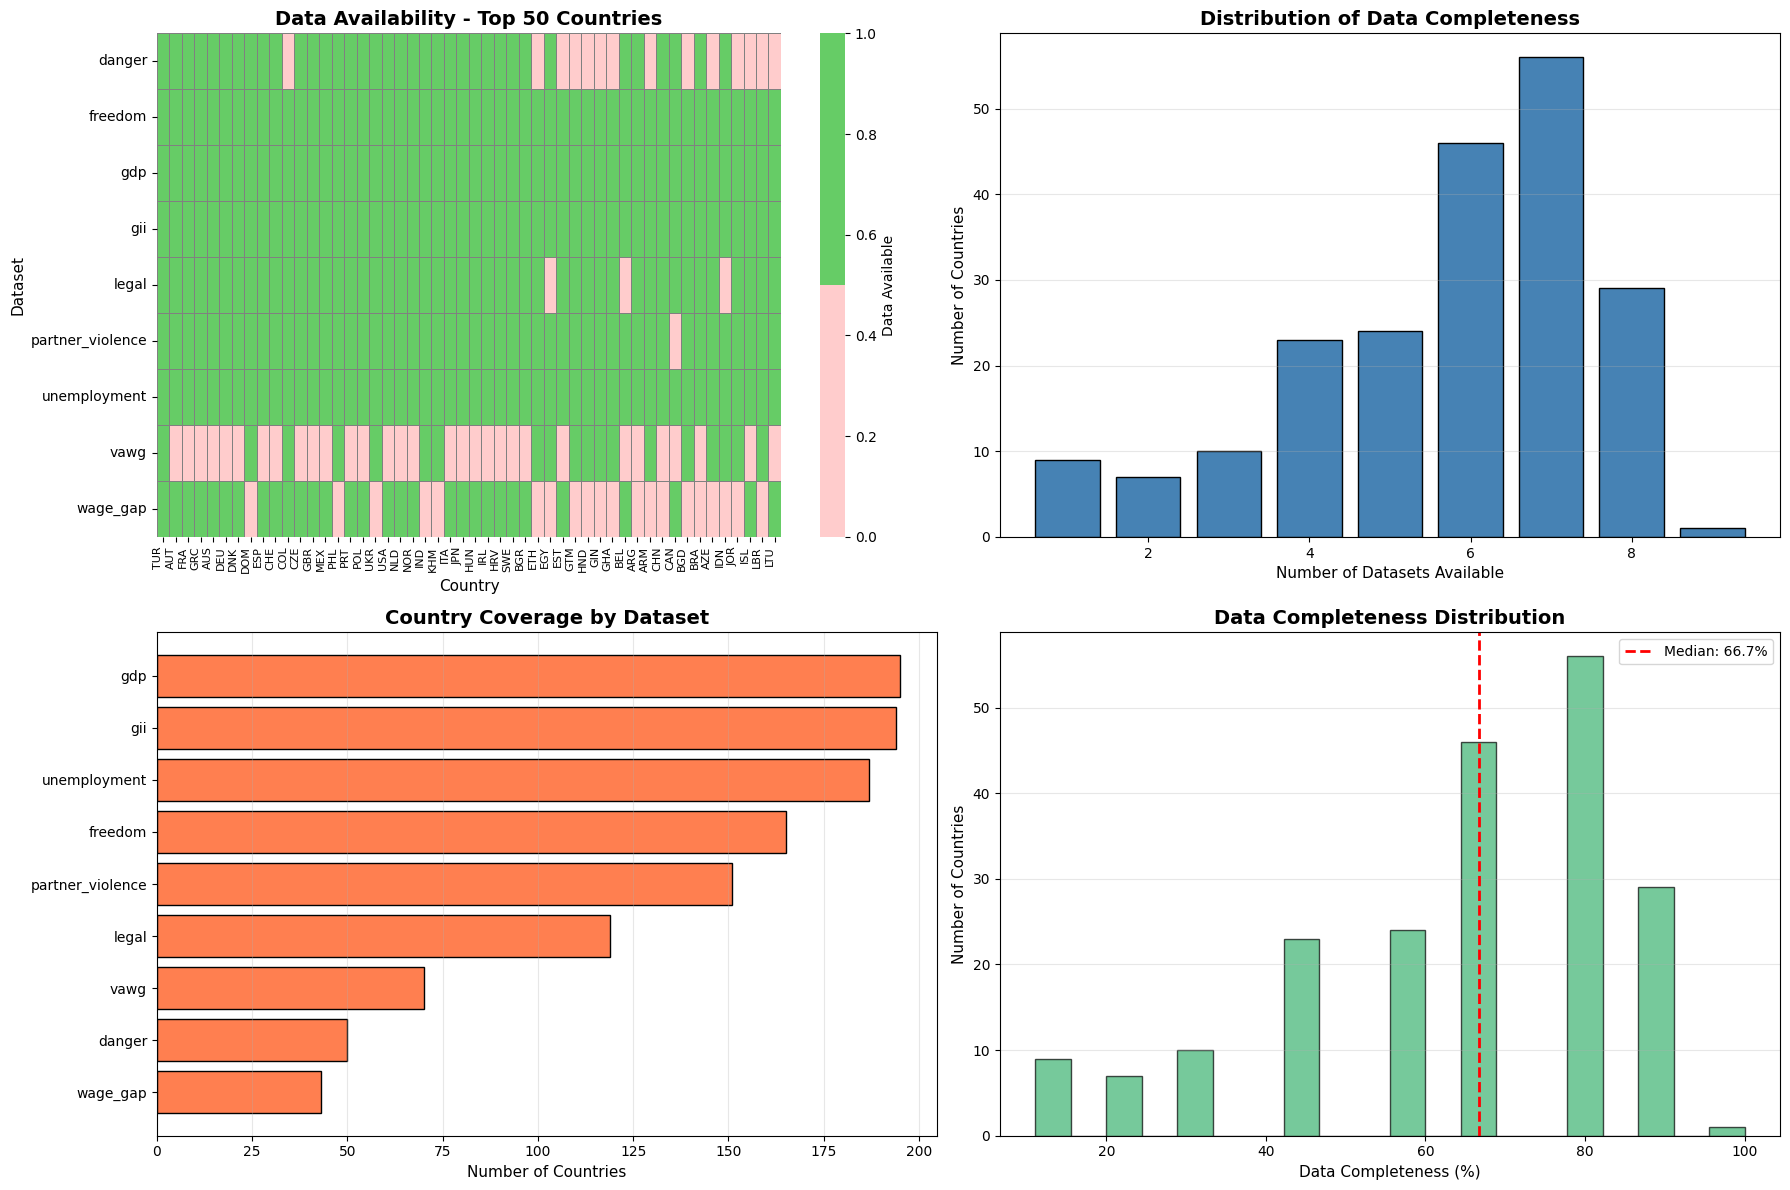

GII HUMAN DEVELOPMENT ENCODING

Original value distribution:
human_development
High         49
Low          32
Medium       44
Very high    66
Name: count, dtype: int64

[nan]

Encoded value distribution:
human_development_encoded
1.0    32
2.0    44
3.0    49
4.0    66
Name: count, dtype: int64

Encoding mapping:
  1 = Low          (32 countries)
  2 = Medium       (44 countries)
  3 = High         (49 countries)
  4 = Very High    (66 countries)


KeyError: "['log_GDP'] not in index"

In [344]:
availability_matrix, summary_stats, master_country_table, merge_stats = run_data_integration_pipeline(datasets)

In [345]:
import plotly.express as px

def plot_data_completeness_map(master_df):
    """
    World map where each country is filled based on data availability percentage.
    """
    fig = px.choropleth(
        master_df,
        locations="iso",                      
        color="data_completeness_%",       
        hover_name="country" if "country" in master_df.columns else "iso",
        color_continuous_scale=px.colors.sequential.OrRd,  
        projection="natural earth",
        title="Global Data Availability by Country",
        labels={"data_completeness_%": "Data Completeness (%)"},
    )

    fig.update_layout(
        title_x=0.5,
        geo=dict(
            showframe=False,
            showcoastlines=True,
            projection_type="natural earth"
        )
    )

    fig.show()

plot_data_completeness_map(master_country_table)

## 6. Saving Processed Data

In [346]:
gii_df_clean = encode_gii_human_development(gii_df_clean)

GII HUMAN DEVELOPMENT ENCODING

Original value distribution:
human_development
High         49
Low          32
Medium       44
Very high    66
Name: count, dtype: int64

[nan]

Encoded value distribution:
human_development_encoded
1.0    32
2.0    44
3.0    49
4.0    66
Name: count, dtype: int64

Encoding mapping:
  1 = Low          (32 countries)
  2 = Medium       (44 countries)
  3 = High         (49 countries)
  4 = Very High    (66 countries)


In [347]:
for name, df in datasets.items():
    file_path = PROCESSED_DIR / f"{name}.csv"
    save_df(df, file_path)

Saved to: C:\Users\black\Documents\Ironhack\final_project\data\processed\domestic.csv
Saved to: C:\Users\black\Documents\Ironhack\final_project\data\processed\vawg.csv
Saved to: C:\Users\black\Documents\Ironhack\final_project\data\processed\freedom.csv
Saved to: C:\Users\black\Documents\Ironhack\final_project\data\processed\danger.csv
Saved to: C:\Users\black\Documents\Ironhack\final_project\data\processed\gdp.csv
Saved to: C:\Users\black\Documents\Ironhack\final_project\data\processed\wage_gap.csv
Saved to: C:\Users\black\Documents\Ironhack\final_project\data\processed\unemployment.csv
Saved to: C:\Users\black\Documents\Ironhack\final_project\data\processed\gii.csv
Saved to: C:\Users\black\Documents\Ironhack\final_project\data\processed\legal.csv
Saved to: C:\Users\black\Documents\Ironhack\final_project\data\processed\partner_violence.csv
Saved to: C:\Users\black\Documents\Ironhack\final_project\data\processed\eq_laws.csv


In [348]:
# save outputs master country-level table 
availability_matrix.to_csv(CLEAN_DIR / "availability_matrix.csv")
summary_stats.to_csv(CLEAN_DIR / "dataset_summary_stats.csv")
master_country_table.to_csv(PROCESSED_DIR / "master_country_table.csv", index=False)
merge_stats.to_csv(CLEAN_DIR / "merge_statistics.csv")